# Credit Card Fraud Detection

# Credit Card Fraud Detection (Imbalanced Classification)

## Why this project
Fraud detection is a high-impact imbalanced classification problem where the cost of false negatives (missed fraud) is often much higher than false positives (unnecessary alerts). The goal is to build a model that ranks transactions by fraud risk and supports threshold decisions that match operational constraints.

## Objective
Train and evaluate classification models that identify fraudulent transactions while managing false alarms.

## Key challenges
- Extreme class imbalance (fraud is rare)
- Accuracy is misleading; evaluation must focus on minority-class performance
- Threshold selection matters: a model score must translate to an actionable alert rule

## What I deliver
- Baseline + multiple models (Logistic Regression, Random Forest, XGBoost)
- Evaluation with PR curve / PR-AUC (primary), plus confusion matrix at a chosen threshold
- Interpretability for the best model (feature importance / SHAP)


In [2]:
# Setup & imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import shap


/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# loading file
df = pd.read_csv("data/creditcard.csv")

df.info()
#check for missing entries
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

no missing values

## EDA

In [6]:
df.corr()['Class'].sort_values(ascending=False)


Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64

In [7]:
df['Class'].value_counts()
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

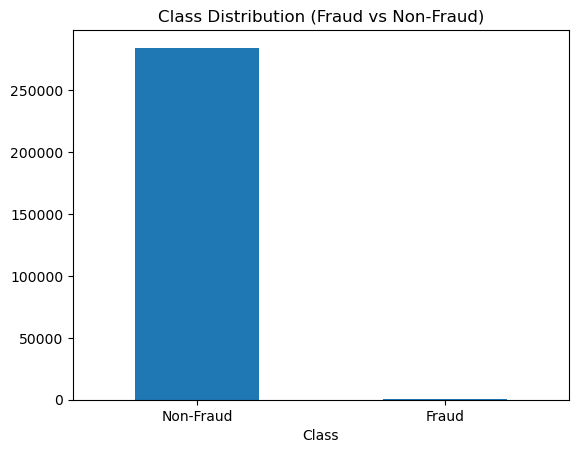

In [8]:
df['Class'].value_counts().plot(kind='bar')
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.xticks([0,1], ['Non-Fraud','Fraud'], rotation=0)
plt.show()

99.8273% non fraud
0.1727% fraud
extremely imbalanced dataset
This means we cannot use accuracy to evaluate the model and we should use precision, recall, and PR-AUC instead.

In [9]:
df.groupby('Class')['Amount'].describe()


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


This means frauds tend to happen at lower amounts compared to legitimate transactions

In [10]:
# fraud rate
class_ratio = df['Class'].value_counts(normalize=True)
fraud_rate = (class_ratio[1] * 100000)
print(f"Fraud rate: {fraud_rate:.2f} frauds per 100,000 transactions")


Fraud rate: 172.75 frauds per 100,000 transactions


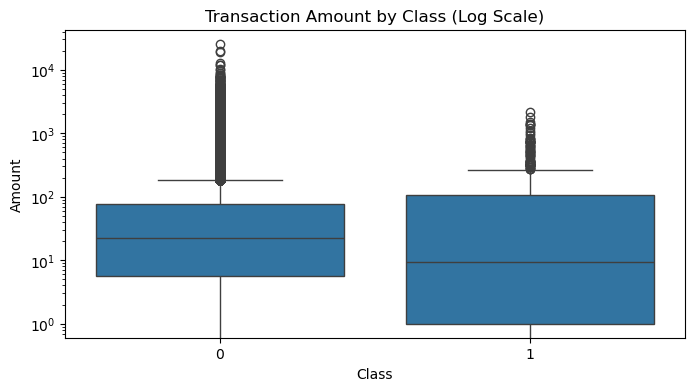

In [11]:

plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.title("Transaction Amount by Class (Log Scale)")
plt.show()


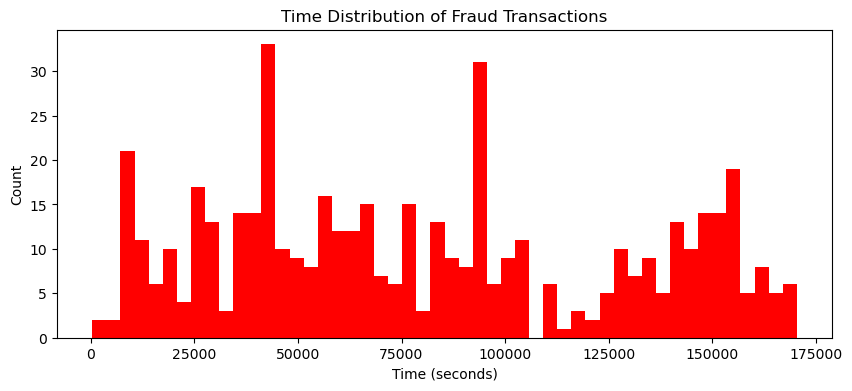

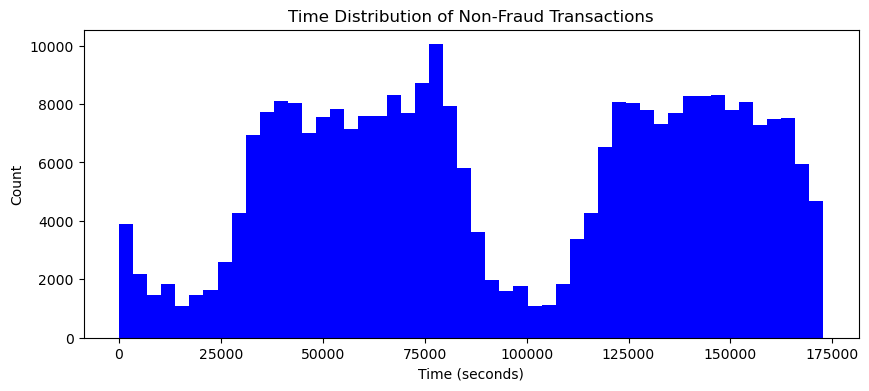

In [12]:
# fraud time distribution histogram
plt.figure(figsize=(10,4))

plt.hist(df[df['Class']==1]['Time'], bins=50, color='red')
plt.title("Time Distribution of Fraud Transactions")
plt.xlabel("Time (seconds)")
plt.ylabel("Count")
plt.show()
# non fraud time distribution histogram
plt.figure(figsize=(10,4))

plt.hist(df[df['Class']==0]['Time'], bins=50, color='blue')
plt.title("Time Distribution of Non-Fraud Transactions")
plt.xlabel("Time (seconds)")
plt.ylabel("Count")
plt.show()


Seperated them since frauds were not visible on a combined histogram due to extreme class imbalance.
No strong temporal clustering of fraud is observed, so the Time feature alone is not sufficient.

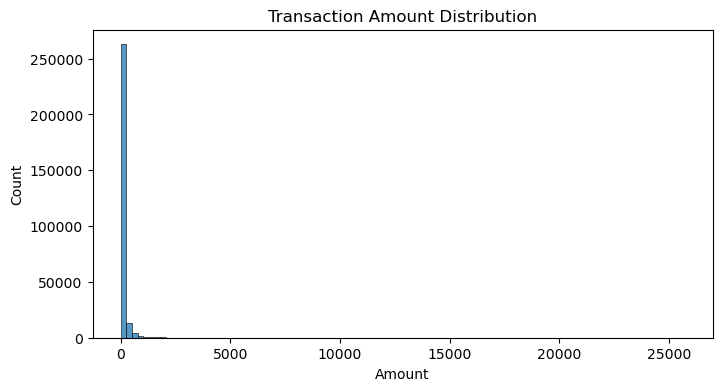

In [13]:
#histogram of amount
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=100)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


Based on this histogram we can tell this is right skewed and we need to apply a log transformation before modeling

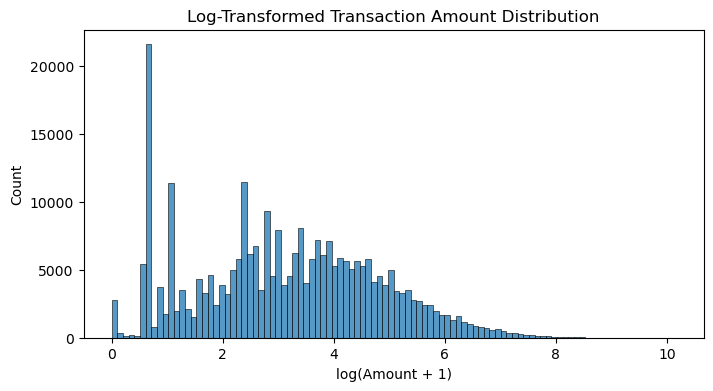

In [14]:

#log transformed histogram of amount
log_amount = np.log1p(df['Amount'])

plt.figure(figsize=(8,4))
sns.histplot(log_amount, bins=100)
plt.title("Log-Transformed Transaction Amount Distribution")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Count")
plt.show()


After applying a log transformation to amounts, the distributio became significantly less skewed and more evenly spread. This also helps stabilizes variance and improves suitability for linear classification models like the logistic regression (baseline).

In [15]:
df['log_amount'] = np.log1p(df['Amount']) #adding log_amount to the df

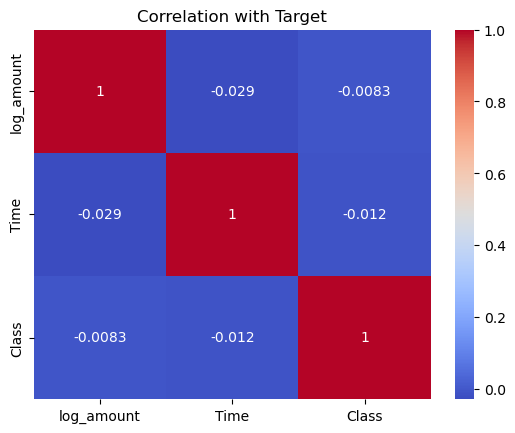

In [16]:
corr = df[['log_amount', 'Time', 'Class']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation with Target")
plt.show()


Since the dataset consisted of PCA-transformed features. A full heatmap would not be 
needed. This heatmap with only log_amount, time, and class shows little to zero correlation.

## Data Preprocessing

Based on exploratory analysis, transaction amount was log-transformed to address severe skewness.  
A stratified train–test split was used to preserve class imbalance.  
Class weighting was applied to address the rarity of fraudulent transactions.


## Baseline: Logistic Regression


In [17]:
X = df.drop(columns=['Class', 'Amount'])  # keep log_amount
y = df['Class']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Stratification was used to preserve class distribution

In [18]:
# scaling for amount (V1-V28 already scaled)

scaler = StandardScaler()

X_train[['log_amount', 'Time']] = scaler.fit_transform(X_train[['log_amount', 'Time']])
X_test[['log_amount', 'Time']] = scaler.transform(X_test[['log_amount', 'Time']])


In [19]:
#baseline logistic regression with class weighing

baseline = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

baseline.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
y_probs = baseline.predict_proba(X_test)[:, 1]
print(y_probs)

[0.00801615 0.05970217 0.00034931 ... 0.00018346 0.00348795 0.09311503]


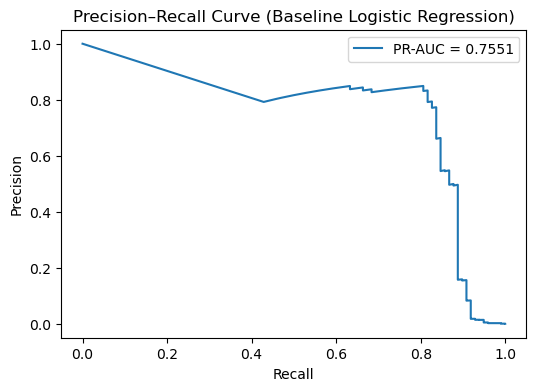

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Baseline Logistic Regression)")
plt.legend()
plt.show()


Baseline model achieved a PR-AUC of 0.76 which indicates a strong seperation between fradulent and legitimate transactions

In [22]:
y_pred_default = (y_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred_default))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [23]:
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_default))

Confusion Matrix (Test):
[[55458  1406]
 [    8    90]]


High recall, poor precision
detected 90/98 of the frauds but also misidentified 1406 non-frauds (false positives)

## Random Forest

In [24]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
y_probs_rf = rf.predict_proba(X_test)[:, 1]

pr_auc_rf = average_precision_score(y_test, y_probs_rf)
print(f"Random Forest PR-AUC: {pr_auc_rf:.4f}")


Random Forest PR-AUC: 0.8451


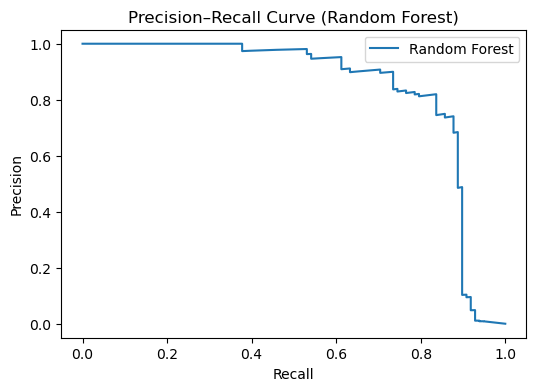

In [26]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_probs_rf)

plt.figure(figsize=(6,4))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.legend()
plt.show()


In [27]:
threshold_rf = 0.20
y_pred_rf = (y_probs_rf >= threshold_rf).astype(int)


In [28]:

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)


Confusion Matrix (Random Forest):
[[56806    58]
 [   11    87]]


## XGBoost

In [29]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight


np.float64(577.2868020304569)

In [30]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [31]:

y_probs_xgb = xgb.predict_proba(X_test)[:, 1]
pr_auc_xgb = average_precision_score(y_test, y_probs_xgb)

print(f"XGBoost PR-AUC: {pr_auc_xgb:.4f}")


XGBoost PR-AUC: 0.8767


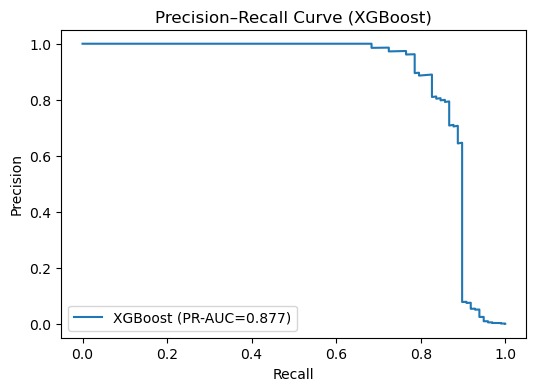

In [32]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_probs_xgb)

plt.figure(figsize=(6,4))
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (PR-AUC={pr_auc_xgb:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.legend()
plt.show()


In [33]:
threshold_xgb = 0.20
y_pred_xgb = (y_probs_xgb >= threshold_xgb).astype(int)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost):")
print(cm_xgb)


Confusion Matrix (XGBoost):
[[56837    27]
 [   13    85]]


In [34]:
# Use a sample for speed; bump to 10k if your machine can handle it
X_shap = X_test.sample(n=min(5000, len(X_test)), random_state=42)


## Model Interpretation (SHAP — XGBoost)


In [35]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap)

# Some versions return a list for binary classification: [class0, class1]
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # use SHAP values for the positive class (fraud)


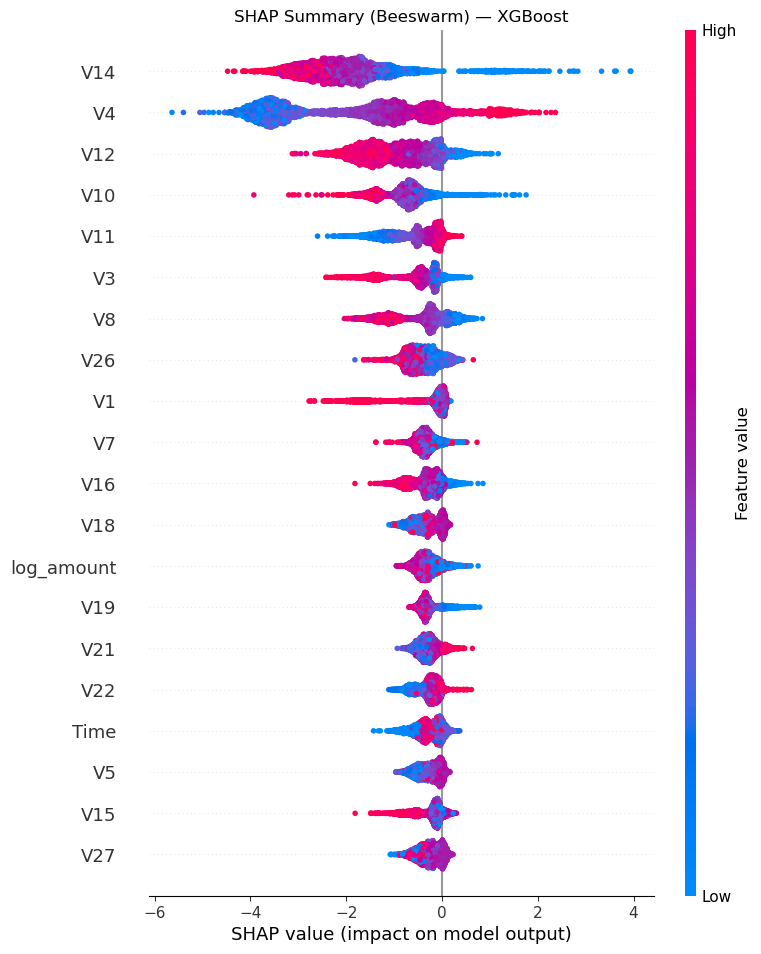

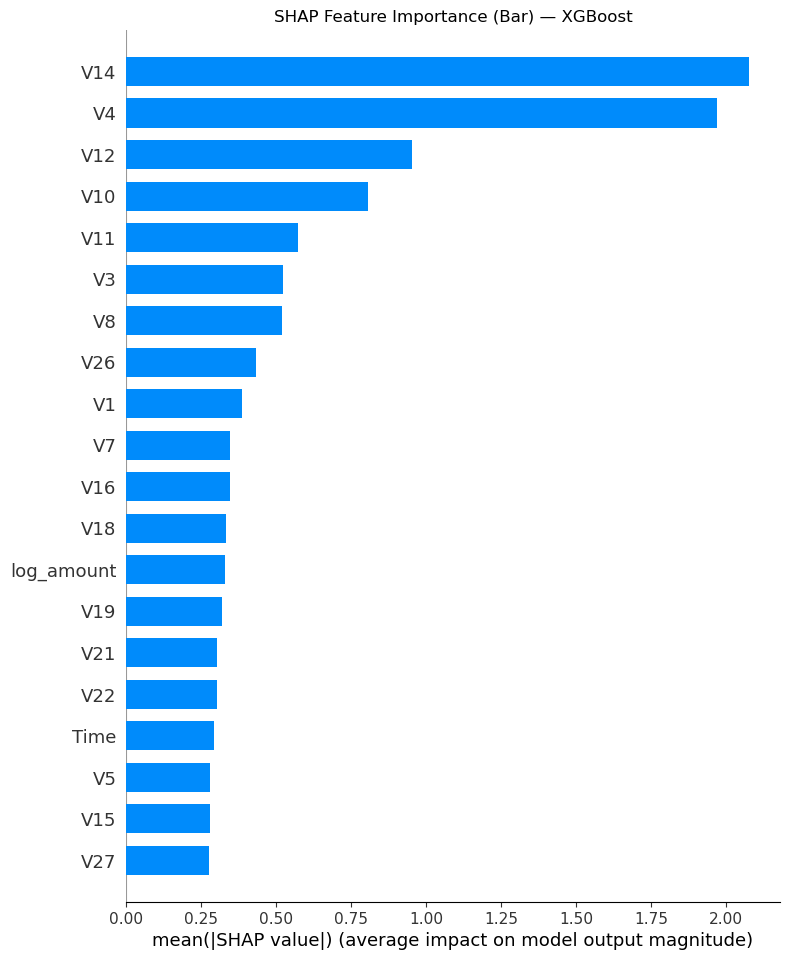

In [37]:
# Beeswarm (shows direction + spread)
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("SHAP Summary (Beeswarm) — XGBoost")
plt.show()

# Bar (global importance by mean |SHAP|)
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar) — XGBoost")
plt.show()


## Model Evaluation

Models were evaluated using precision–recall metrics due to severe class imbalance.  
Performance was compared using confusion matrices, PR-AUC, and operational error counts.


In [36]:

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.87      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962



| Model | Precision (Fraud) | Recall (Fraud) | False Positives | False Negatives |
|------|-------------------|---------------|----------------|----------------|
| Logistic Regression | ~0.06 | ~0.92 | ~1406 | 8 |
| Random Forest | ~0.60 | ~0.89 | 58 | 11 |
| XGBoost | **0.76** | **0.87** | **27** | **13** |


The table above summarizes performance across the 3 models evaluated.

## Model Selection Summary

While logistic regression achieved high recall, it generated an impractical number of false positives.  
Random Forest improved precision significantly, but XGBoost provided the best overall trade-off by further reducing false positives while maintaining strong fraud recall.  
As a result, XGBoost was selected as the final model for its effectiveness in cost-sensitive fraud detection.

